In [1]:
import time
import operator
from functools import partial
from concurrent.futures import ProcessPoolExecutor
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.spatial.distance import correlation as dcorrelation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split

sns.set(style="white")
%matplotlib inline

In [2]:
def gen_confusion_matrix(y, yh):
    cls = np.unique(y)
    confusion_m = np.zeros((cls.size, cls.size))
    for i, yhto in enumerate(y):
        for cl in cls:
            if yhto == yh[i] and yhto == cl:
                confusion_m[cl, cl] += 1
                break
            elif yhto != yh[i]:
                confusion_m[yhto, yh[i]] += 1
                break
    return confusion_m

def gen_classification_report(confusion_m):
    cls, _ = confusion_m.shape
    cls = range(cls)
    report = {(i+1): {"precision": 0, "recall": 0, "f1-score": 0, "support": 0} for i in cls}
    for r in cls:
        for c in cls:
            if r == c:
                tp = confusion_m[r, c]
                tn = np.diagonal(confusion_m) - tp
                fp = np.sum(confusion_m[:, c])
                fn = np.sum(confusion_m[r, :])
                P, R = np.round(tp / fp, 2), np.round(tp / fn, 2)
                report[r+1]["support"] = tp + (fn - tp)
                report[r+1]["precision"] = P
                report[r+1]["recall"] = R
                report[r+1]["f1-score"] = np.round((2 * (P * R)) / (P + R), 2)
    return report

def one_hot_encode(y):
    return pd.get_dummies(y).values

class LogisticRegressionImpl():
        
    def __init__(self, fit_intercept=True, decay=1e-4, batch_size=32, weights=None):
        self.w = weights
        self.fit_intercept = fit_intercept
        self._decay = decay
        self._batch_size = batch_size
    
    def _one_hot_encode(self, y):
        return pd.get_dummies(y).values
        
    def __softmax(self, z):
        e_x = np.exp(z.T - np.max(z, axis=1)) 
        return (e_x / e_x.sum(axis=0)).T
    
    def __sigmoid(self, z):
        return 1./(1 + np.exp(-z))
    
    def _add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
    
    def _shuffle(self, X, y):
        permutation = np.random.permutation(X.shape[0])
        if self.__cls > 2:
            return X[permutation, :], y[permutation, :]
        return X[permutation, :], y[permutation]
    
    def train(self, x, y, lr=1e-4, epochs=10000):
        # Check to see the number of classes 
        uniq = np.unique(y)
        self.__activation = self.__sigmoid
        self.__cls = uniq.shape[0]
        if self.__cls > 2:
            y = self._one_hot_encode(y)
            self.__activation = self.__softmax
        # Train and validation sets
        x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=0.7)
        # Should we add a intercept
        x_train, x_val = self._add_intercept(x_train), self._add_intercept(x_val)
        # Number of samples
        self.N = y.size
        # Initialize weights
        if self.w is None:
            self.w = np.random.rand(x_train.shape[1], ) * np.sqrt(2 / (self.N + 2))
            if self.__cls > 2:
                self.w = np.random.rand(x_train.shape[1], self.__cls) * np.sqrt(2 / (self.N + self.__cls))

        # Train loop Gradient Descent
        J, ACC = [], []
        mb = np.ceil(x_train.shape[0] / self._batch_size).astype(np.int32)
        for i in range(epochs):
            # Shuffle dataset in each epoch
            x_train, y_train = self._shuffle(x_train.copy(), y_train.copy())
            r = 0
            for _ in range(mb):
                # Mini batch crop
                ini, end = r * self._batch_size, (r + 1) * self._batch_size
                batch_X, batch_y = x_train[ini:end, :], y_train[ini:end]
                if self.__cls > 2:
                    batch_X, batch_y = x_train[ini:end, :], y_train[ini:end, :]
                r += 1
                # Forward
                yh = self.__activation(np.dot(batch_X, self.w))
                # Gradient
                dw = (1 / self.N) * np.dot(batch_X.T, (yh - batch_y))
                # Weight adjust with regularization
                self.w = (self.w - (lr * dw)) - (((lr * self._decay) / self.N) * self.w)
            # Validation Loss
            h = self.__activation(np.dot(x_val, self.w))
            # Accuracy
            ACC.append(np.round(self.__acc(y_val, h), 5))
            # Loss
            J.append(np.round(self.__loss(y_val, h), 5))
        return J, ACC

    def predict_proba(self, x):
        x = self._add_intercept(x)
        return self.__activation(np.dot(x, self.w))
    
    def predict(self, x, threshold=0.5):
        if self.__cls > 2:
            return np.argmax(self.predict_proba(x), axis=1)
        return (self.predict_proba(x) >= threshold).astype(np.int)
    
    def __acc(self, y, yh):
        Y, YH = y, (yh >= .5).astype(np.int)
        if self.__cls > 2:
            Y, YH = np.argmax(y, axis=1), np.argmax(yh, axis=1)
        return (
                np.round(
                    np.mean([y == yh for y, yh in zip(Y, YH)]), 2
                )
                * 100
            )
    
    def __loss(self, y, yh):
        L2 = (self._decay / (2 * self.N)) * np.sum([np.sum(np.square(w)) for w in self.w])
        if self.__cls > 2:
            n_samples = y.shape[0]
            logp = -np.log(yh[np.arange(n_samples), y.argmax(axis=1)])
            loss = np.sum(logp) / n_samples
            return loss + L2
        bce = -np.sum(np.multiply(y, np.log(yh)) + np.multiply((1-y), np.log(1 - yh)))
        return ((1 / self.N) * bce) + L2

# IA006 - Exercícios de Fixação de Conceitos

$~$

## EFC2 - 2s2019

$~$

### Parte 1 - Classificação Binária

$~$

**Problema:** identificação do gênero do locutor apartir de trechos de voz

**Dataset:** https://www.mldata.io/dataset-details/gender_voice/

Descrição dos dados:

* Showing 15 out of 21 attributes.

| Name | Type | Description |
|------|------|-------------|
| meanfreq | float | mean frequency (in kHz) |
| sd | float | standard deviation of frequency |
| median | float | median frequency (in kHz) |
| Q25 | float | first quantile (in kHz) |
| Q75 | float | third quantile (in kHz) |
| IQR | float | interquantile range (in kHz) |
| skew | float | skewness (see note in specprop description) |
| kurt | float | kurtosis (see note in specprop description) |
| sp.ent | float | spectral entropy |
| sfm | float | spectral flatness |
| mode | float | mode frequency |
| centroid | float | frequency centroid (see specprop) |
| meanfun | float | average of fundamental frequency measured across acoustic signal |
| minfun | float | minimum fundamental frequency measured across acoustic signal |
| label | string | Predictor class, male or female |


Apresentação dos 5 primeiros dados:

In [3]:
df = pd.read_csv("dados_voz_genero.csv")
print(df.head(5))

         sd    median       Q25       Q75       IQR       skew         kurt  \
0  0.064241  0.032027  0.015071  0.090193  0.075122  12.863462   274.402906   
1  0.067310  0.040229  0.019414  0.092666  0.073252  22.423285   634.613855   
2  0.083829  0.036718  0.008701  0.131908  0.123207  30.757155  1024.927705   
3  0.072111  0.158011  0.096582  0.207955  0.111374   1.232831     4.177296   
4  0.079146  0.124656  0.078720  0.206045  0.127325   1.101174     4.333713   

     sp.ent       sfm      mode  centroid   meanfun    minfun    maxfun  \
0  0.893369  0.491918  0.000000  0.059781  0.084279  0.015702  0.275862   
1  0.892193  0.513724  0.000000  0.066009  0.107937  0.015826  0.250000   
2  0.846389  0.478905  0.000000  0.077316  0.098706  0.015656  0.271186   
3  0.963322  0.727232  0.083878  0.151228  0.088965  0.017798  0.250000   
4  0.971955  0.783568  0.104261  0.135120  0.106398  0.016931  0.266667   

    meandom    mindom    maxdom   dfrange   modindx  label  
0  0.007812  

$~$

**a)** Análise estatística dos dados

A análise estatística será feita particularmente em apenas um subset do conjunto total de features, que são: *sd, median, skew, kurt, sp.ent, sfm, mode, centroid, meanfun, meandom*.

Entretanto a matriz de correlação pearson será apresentada para todo o dataset.

In [4]:
fields = ["sd", "median", "skew", "kurt", "sp.ent", "sfm", "mode", "centroid", "meanfun", "meandom", "label"]
x_fields = fields[:10]
sound_c = df[fields]

In [5]:
data = []
for field in x_fields:
    unique_elements, counts_elements = np.unique(sound_c[field], return_counts=True)
    data.append([
        field,
        len(sound_c[field]),
        np.round(np.min(sound_c[field]), 3),
        np.round(np.max(sound_c[field]), 3),
        np.round(np.mean(sound_c[field]), 3),
        np.round(np.median(sound_c[field]), 3),
        np.round(np.var(sound_c[field]), 3),
        np.round(np.std(sound_c[field]), 3),
        len(counts_elements)
    ])
df2 = pd.DataFrame(data, columns=["Field", "Qtd", "Min", "Max", "Mean", "Median", "Var.", "Std", "Unique"])
print(df2)

      Field   Qtd    Min       Max    Mean  Median       Var.      Std  Unique
0        sd  3168  0.018     0.115   0.057   0.059      0.000    0.017    3166
1    median  3168  0.011     0.261   0.186   0.190      0.001    0.036    3077
2      skew  3168  0.142    34.725   3.140   2.197     17.976    4.240    3166
3      kurt  3168  2.068  1309.613  36.568   8.318  18199.997  134.907    3166
4    sp.ent  3168  0.739     0.982   0.895   0.902      0.002    0.045    3166
5       sfm  3168  0.037     0.843   0.408   0.396      0.032    0.177    3166
6      mode  3168  0.000     0.280   0.165   0.187      0.006    0.077    2825
7  centroid  3168  0.039     0.251   0.181   0.185      0.001    0.030    3166
8   meanfun  3168  0.056     0.238   0.143   0.141      0.001    0.032    3166
9   meandom  3168  0.008     2.958   0.829   0.766      0.276    0.525    2999


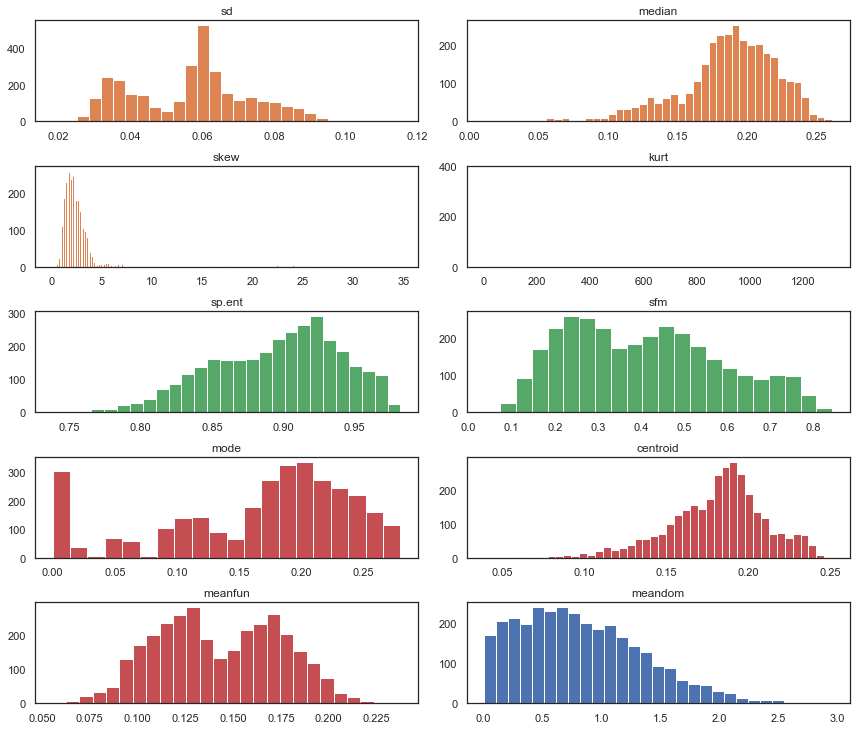

In [6]:
plt.figure(figsize=(12, 12))
plt.subplot(6, 2, 1)
plt.title("sd")
plt.hist(sound_c["sd"], bins='auto', color="C1")
plt.subplot(6, 2, 2)
plt.title("median")
plt.hist(sound_c["median"], bins='auto', color="C1")
plt.subplot(6, 2, 3)
plt.title("skew")
plt.hist(sound_c["skew"], bins='auto', color="C1")
plt.subplot(6, 2, 4)
plt.title("kurt")
plt.hist(sound_c["kurt"], bins='auto', color="C2")
plt.subplot(6, 2, 5)
plt.title("sp.ent")
plt.hist(sound_c["sp.ent"], bins='auto', color="C2")
plt.subplot(6, 2, 6)
plt.title("sfm")
plt.hist(sound_c["sfm"], bins='auto', color="C2")
plt.subplot(6, 2, 7)
plt.title("mode")
plt.hist(sound_c["mode"], bins='auto', color="C3")
plt.subplot(6, 2, 8)
plt.title("centroid")
plt.hist(sound_c["centroid"], bins='auto', color="C3")
plt.subplot(6, 2, 9)
plt.title("meanfun")
plt.hist(sound_c["meanfun"], bins='auto', color="C3")
plt.subplot(6, 2, 10)
plt.title("meandom")
plt.hist(sound_c["meandom"], bins='auto')
plt.tight_layout()
plt.show()

Como é possível observar alguns dos atributos tem o perfil de seu histograma próximo ao formato de uma distribuição gaussiana. Abaixo, são apresentados as Densidades de Probabilidade dos mesmos dados, entretanto escalonados usado a seguinte operação:

$~$

$y = \frac{x-\mu}{\sigma}$

$~$

onde $\mu$ é a média e $\sigma$ a variância de cada coluna.

In [7]:
scaler = StandardScaler()
scaler.fit_transform(sound_c[x_fields])
nsound_c = scaler.transform(sound_c[x_fields])
sound_c = pd.DataFrame(np.c_[nsound_c, sound_c["label"].to_numpy()], columns=fields)

In [8]:
data = []
for field in x_fields:
    unique_elements, counts_elements = np.unique(sound_c[field], return_counts=True)
    data.append([
        field,
        len(sound_c[field]),
        np.round(np.min(sound_c[field]), 5),
        np.round(np.max(sound_c[field]), 5),
        np.round(np.mean(sound_c[field]), 5),
        np.round(np.median(sound_c[field]), 5),
        np.round(np.var(sound_c[field]), 5),
        np.round(np.std(sound_c[field]), 5),
        len(counts_elements)
    ])
df2 = pd.DataFrame(data, columns=["Field", "Qtd", "Min", "Max", "Mean", "Median", "Var.", "Std", "Unique"])
print(df2)

      Field   Qtd      Min      Max  Mean   Median  Var.  Std  Unique
0        sd  3168 -2.32814  3.49241  -0.0  0.12187   1.0  1.0    3166
1    median  3168 -4.80399  2.07963  -0.0  0.12135   1.0  1.0    3077
2      skew  3168 -0.70720  7.44961  -0.0 -0.22243   1.0  1.0    3166
3      kurt  3168 -0.25573  9.43643   0.0 -0.20940   1.0  1.0    3166
4    sp.ent  3168 -3.47939  1.93162   0.0  0.14764   1.0  1.0    3166
5       sfm  3168 -2.09214  2.44922   0.0 -0.06694   1.0  1.0    3166
6      mode  3168 -2.14121  1.48616   0.0  0.27616   1.0  1.0    2825
7  centroid  3168 -4.73181  2.34737  -0.0  0.13144   1.0  1.0    3166
8   meanfun  3168 -2.70103  2.93596  -0.0 -0.07084   1.0  1.0    3166
9   meandom  3168 -1.56420  4.05329   0.0 -0.12076   1.0  1.0    2999


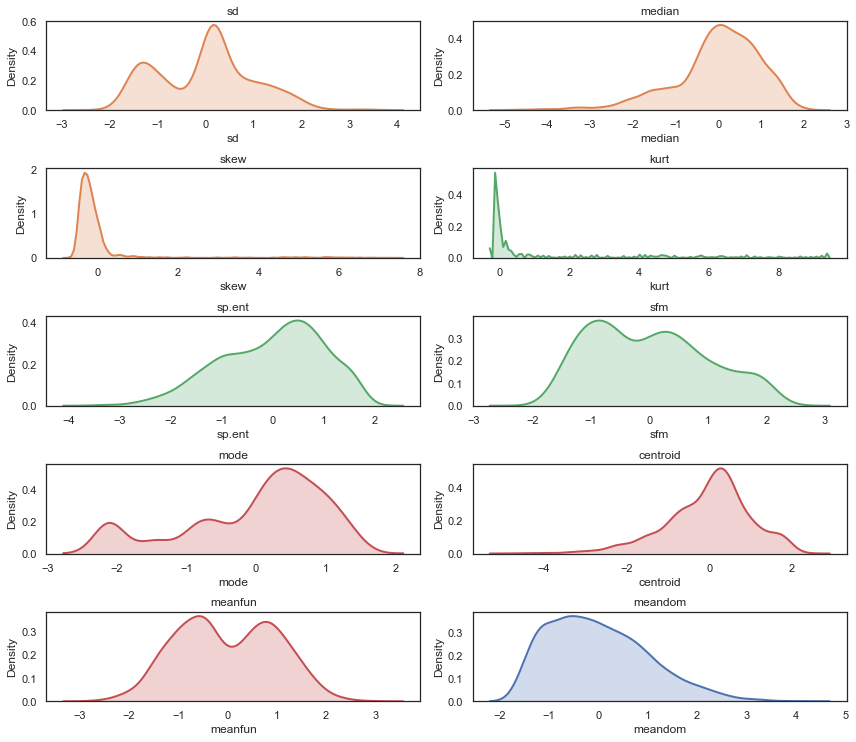

In [9]:
kds = {'shade': True, 'linewidth': 2}

plt.figure(figsize=(12, 12))
plt.subplot(6, 2, 1)
plt.title("sd")
sns.distplot(sound_c["sd"], hist=False, kde=True, kde_kws=kds, color="C1")
plt.ylabel('Density')
plt.subplot(6, 2, 2)
plt.title("median")
sns.distplot(sound_c["median"], hist=False, kde=True, kde_kws=kds, color="C1")
plt.ylabel('Density')
plt.subplot(6, 2, 3)
plt.title("skew")
sns.distplot(sound_c["skew"], hist=False, kde=True, kde_kws=kds, color="C1")
plt.ylabel('Density')
plt.subplot(6, 2, 4)
plt.title("kurt")
sns.distplot(sound_c["kurt"], hist=False, kde=True, kde_kws=kds, color="C2")
plt.ylabel('Density')
plt.subplot(6, 2, 5)
plt.title("sp.ent")
sns.distplot(sound_c["sp.ent"], hist=False, kde=True, kde_kws=kds, color="C2")
plt.ylabel('Density')
plt.subplot(6, 2, 6)
plt.title("sfm")
sns.distplot(sound_c["sfm"], hist=False, kde=True, kde_kws=kds, color="C2")
plt.ylabel('Density')
plt.subplot(6, 2, 7)
plt.title("mode")
sns.distplot(sound_c["mode"], hist=False, kde=True, kde_kws=kds, color="C3")
plt.ylabel('Density')
plt.subplot(6, 2, 8)
plt.title("centroid")
sns.distplot(sound_c["centroid"], hist=False, kde=True, kde_kws=kds, color="C3")
plt.ylabel('Density')
plt.subplot(6, 2, 9)
plt.title("meanfun")
sns.distplot(sound_c["meanfun"], hist=False, kde=True, kde_kws=kds, color="C3")
plt.ylabel('Density')
plt.subplot(6, 2, 10)
plt.title("meandom")
sns.distplot(sound_c["meandom"], hist=False, kde=True, kde_kws=kds)
plt.ylabel('Density')
plt.tight_layout()
plt.show()

Através da matriz de correlação, podemos ter uma ideia de como as features de nosso dataset estão correlacionadas entre si.

Nota-se uma correlação relativamente alta entre os campos *meanfun* e o *label*. O que permite inferir que esse atributo terá forte influência na classificaçãod dos resultados.

Evitando, encontrar apenas correlações lineares entres os valores, aplica-se também a Correlação em Distância, a qual possibilita visualizar valores de correlação não lineares entre variáveis e também avaliar a indepedência das variáveis (quando o valor for zero).

A Correlação em Distância, também exemplifica o apresentado acima a respeito do atributo *meanfun*.

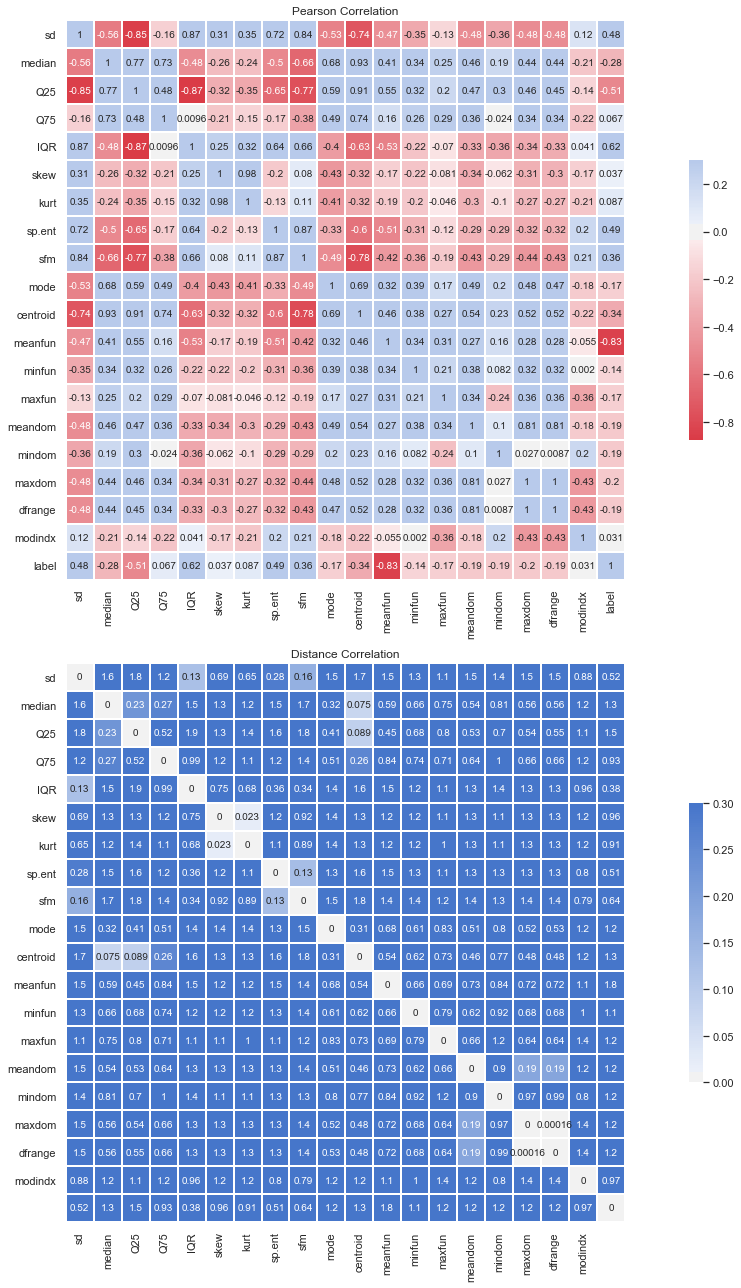

In [10]:
cols = df.columns
fields = cols[:len(cols)-1].to_numpy()

scaler2 = StandardScaler()
df = pd.DataFrame(np.c_[scaler2.fit_transform(df[fields]), df["label"].to_numpy()], columns=cols)

# Pearson Correlation
corr = df.corr()

# Distance Correlation
ds = len(cols)
dcorr = np.zeros((ds, ds))
for i, field in enumerate(cols):
    for k, field2 in enumerate(cols):
        dcorr[i][k] = dcorrelation(df[field], df[field2])


cmap = sns.diverging_palette(10, 255, as_cmap=True)

plt.figure(figsize=(18, 18))
plt.subplot(2, 1, 1)
plt.title("Pearson Correlation")
ax = sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=1, annot=True, cbar_kws={"shrink": .5})
ax.set_ylim(ds, 0)
plt.subplot(2, 1, 2)
plt.title("Distance Correlation")
ax = sns.heatmap(dcorr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=1, annot=True, cbar_kws={"shrink": .5},
            xticklabels=fields, yticklabels=fields
)
ax.set_ylim(ds, 0)
plt.tight_layout()
plt.show()

Abaixo alguns gráficos o quais apresentam a distribuição de algumas das correlações entre os atributos do dataset. Para que seja possível observar essa correlação linear ou não linear.

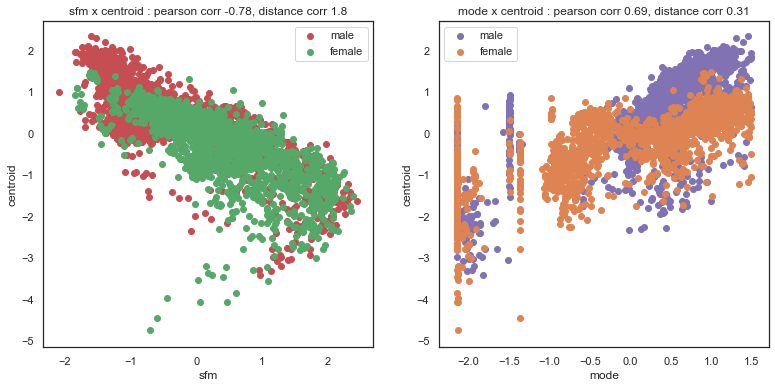

In [11]:
labels, colors, colors2 = ("male", "female"), ("C3", "C2"), ("C4", "C1")
plt.figure(figsize=(13, 6))
plt.subplot(1, 2, 1)
for i, color, label in zip([0, 1], colors, labels):
    sfm = sound_c[sound_c["label"] == i]["sfm"]
    centroid = sound_c[sound_c["label"] == i]["centroid"]
    plt.scatter(sfm, centroid, c=color, label=label)
plt.title("sfm x centroid : pearson corr -0.78, distance corr 1.8")
plt.xlabel("sfm")
plt.ylabel("centroid")
plt.legend()
plt.subplot(1, 2, 2)
for i, color, label in zip([0, 1], colors2, labels):
    sfm = sound_c[sound_c["label"] == i]["mode"]
    centroid = sound_c[sound_c["label"] == i]["centroid"]
    plt.scatter(sfm, centroid, c=color, label=label)
plt.title("mode x centroid : pearson corr 0.69, distance corr 0.31")
plt.xlabel("mode")
plt.ylabel("centroid")
plt.legend()
plt.show()

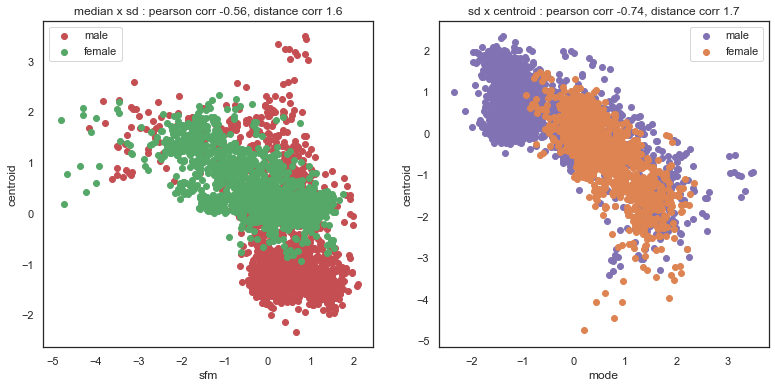

In [12]:
labels, colors, colors2 = ("male", "female"), ("C3", "C2"), ("C4", "C1")
plt.figure(figsize=(13, 6))
plt.subplot(1, 2, 1)
for i, color, label in zip([0, 1], colors, labels):
    sfm = sound_c[sound_c["label"] == i]["median"]
    centroid = sound_c[sound_c["label"] == i]["sd"]
    plt.scatter(sfm, centroid, c=color, label=label)
plt.title("median x sd : pearson corr -0.56, distance corr 1.6")
plt.xlabel("sfm")
plt.ylabel("centroid")
plt.legend()
plt.subplot(1, 2, 2)
for i, color, label in zip([0, 1], colors2, labels):
    sfm = sound_c[sound_c["label"] == i]["sd"]
    centroid = sound_c[sound_c["label"] == i]["centroid"]
    plt.scatter(sfm, centroid, c=color, label=label)
plt.title("sd x centroid : pearson corr -0.74, distance corr 1.7")
plt.xlabel("mode")
plt.ylabel("centroid")
plt.legend()
plt.show()

De acordo com a análise estatística apresentada acima, podemos usar apenas os seguintes campos do dataset para conseguir uma acurácia em torno de 96% (*sd, median, sp.ent, sfm, centroid, meanfun, meandom*).

Outros campos analisados como *skew* e *kurt*, tem baixa correlação com o label final e o campo *mode* tem uma forte correlação com todos os outros campos mas também relativamente baixa com o label.

$~$

**b)** Implementar a Regressão Logística e apresentar os valores da curva ROC e F1-Score em função do threshold.

O modelo de Regressão Logística implementado possui 5 hiperparâmetros, que podem ser alterados, são eles:

 - Regularização => valor padrão : 1e-4 (L2)
 - Learning rate => valor padrão : 1e-4
 - Épocas do algoritmo de GD => valor padrão : 10000
 - Batch Size => valor padrão : 32
 - Threshold de classificação => valor padrão : 0.5 (apenas para classificação binária)

O classificador implementa o processo iterativo conhecido como Gradiente Descendente no mini-batch passado. Além disso, ele valida os dados em um pequeno subset (30% dos dados de treinamento).

Nos testes iniciais o único valor padrão alterado foi de learning rate, alterado de 1e-4 para 1e-1, para que o modelo possa convergir no melhor ponto dentro da quantidade de épocas padrão. Neste algoritmo não foi implementado Early Stop, mas esta implementado a utilização de mini-batch.

Conforme mencionado em aula, apesar da análise estatística apresentar uma possível seleção de atributos, no caso do classificador serão utilizados todos os dados (todos os dados escalonados).

Executando o classificador obtemos as seguintes visualizações, respectivamente, da Curva ROC, a evolução da métrica F-Score e da Acurácia de acordo com o Threshold.

In [13]:
fields = cols[:len(cols)-1].to_numpy()
x = np.copy(df[fields].to_numpy())
y = np.copy(df["label"].to_numpy())
# train test split 20%
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8)

In [14]:
# Logistic function
clf = LogisticRegressionImpl()
J, ACC = clf.train(x_train, y_train, lr=1e-1)

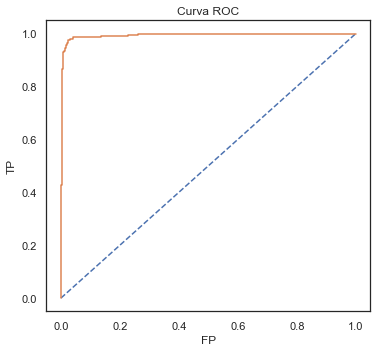

In [15]:
probs = clf.predict_proba(x_test)
fpr, tpr, thresholds = roc_curve(y_test, probs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Curva ROC")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlabel("FP")
plt.ylabel("TP")
plt.tight_layout()
plt.show()

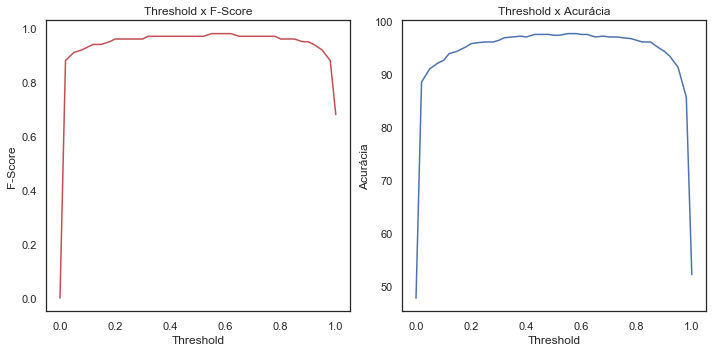

Resultados:
------------------------------
    Threshold  Acurácia  Erros  Recall  Precisão  F-Score
22       0.55     97.63   2.37    0.98      0.98     0.98
23       0.58     97.63   2.37    0.98      0.98     0.98
24       0.60     97.48   2.52    0.98      0.98     0.98
25       0.62     97.48   2.52    0.98      0.98     0.98
17       0.43     97.48   2.52    0.98      0.97     0.97
18       0.45     97.48   2.52    0.98      0.97     0.97
19       0.48     97.48   2.52    0.98      0.97     0.97
20       0.50     97.32   2.68    0.98      0.97     0.97
21       0.52     97.32   2.68    0.98      0.97     0.97
15       0.38     97.16   2.84    0.98      0.96     0.97


In [16]:
def calculate_resultados(y_test, y_pred):
    with np.errstate(all='ignore'):
        cfm = confusion_matrix(y_test, y_pred)
        acertos = cfm[0, 0] + cfm[1, 1]
        erros = cfm[0, 1] + cfm[1, 0]
        precisao = np.round(cfm[0, 0] / (cfm[0, 0] + cfm[0, 1]), 2)
        recall = np.round(cfm[0, 0] / (cfm[0, 0] + cfm[1, 0]), 2)
        fscore = np.round((2 * recall * precisao) / (recall + precisao), 2)
        acuracia = np.round(acertos / len(y_test) * 100, 2)
        erros = np.round(erros / len(y_test) * 100, 2)
    return acuracia, erros, recall, precisao, fscore
    
def print_resultados(acuracia, erros, recall, precisao, fscore):
    print("Acurácia:")
    print("-" * 30)
    print(f"Acertos: {acuracia}%")
    print(f"Erros  : {erros}%")
    print()
    print("Recall | Precisão | F-Score")
    print("-" * 30)
    print(f"{recall}   | {precisao}     | {fscore}")


resultados = []
for thre in np.linspace(0, 1, 41):
    thre = np.round(thre, 2)
    y_pred = clf.predict(x_test, threshold=thre)
    resultados.append(np.concatenate((np.array([thre]), calculate_resultados(y_test, y_pred))))
resultados = np.nan_to_num(np.array(resultados))

df = pd.DataFrame(resultados, columns=["Threshold", "Acurácia", "Erros", "Recall", "Precisão", "F-Score"])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Threshold x F-Score")
plt.plot(df["Threshold"], df["F-Score"], c="C3")
plt.xlabel("Threshold")
plt.ylabel("F-Score")
plt.subplot(1, 2, 2)
plt.title("Threshold x Acurácia")
plt.plot(df["Threshold"], df["Acurácia"], c="C0")
plt.xlabel("Threshold")
plt.ylabel("Acurácia")
plt.tight_layout()
plt.show()

ordered = df.sort_values(by=["F-Score", "Acurácia"], ascending=False)

print("Resultados:")
print("-" * 30)
print(ordered.head(10))

A curva ROC apresenta a qualidade do classificador e a evolução da F-medida permite encontrar um melhor threshold para os dados.
Entretanto tal alternativa é realmente válida para classificação binária, visto que principalmente a curva ROC e o threshold são escolhas realizadas entre até 2 elementos.

Talvez uma alternativa para multi-classes, seria algo como gerar a curva ROC e o threshold para uma estrutura um-contra-todos, por exemplo.

$~$

**c)** Melhor valor do threshold e matriz de confusão dos resultados.

Abaixo será aplicado o melhor de threshold encontrado e observado na tabela acima.

In [17]:
best_threshold = ordered["Threshold"].to_numpy()[0]
print(f"Melhor threshold encontrado usando os experimentos acima: {best_threshold}")
print()

y_pred = clf.predict(x_test, threshold=best_threshold)

print("Acurácia:")
print("-" * 30)
print(f"Acertos: {np.round(accuracy_score(y_test, y_pred) * 100, 2)}%")
print(f"Erros  : {np.round((1-accuracy_score(y_test, y_pred)) * 100, 2)}%")

print()
print("Relatório de Classificação:")
print("-" * 30)
report = classification_report(y_test.astype(np.int), y_pred.astype(np.int), output_dict=True)
items = []
for key, value in report.items():
    if isinstance(value, dict) and key.isdigit():
        items.append([
            key,
            np.round(value["precision"], 2),
            np.round(value["recall"], 2),
            np.round(value["f1-score"], 2),
            np.round(value["support"], 2)
        ])
dfclass = pd.DataFrame(items, columns=["Classe", "Precisão", "Recall", "F1-Score", "Support"])
print(dfclass)

Melhor threshold encontrado usando os experimentos acima: 0.55

Acurácia:
------------------------------
Acertos: 97.63%
Erros  : 2.37%

Relatório de Classificação:
------------------------------
  Classe  Precisão  Recall  F1-Score  Support
0      0      0.98    0.98      0.98      331
1      1      0.97    0.98      0.98      303


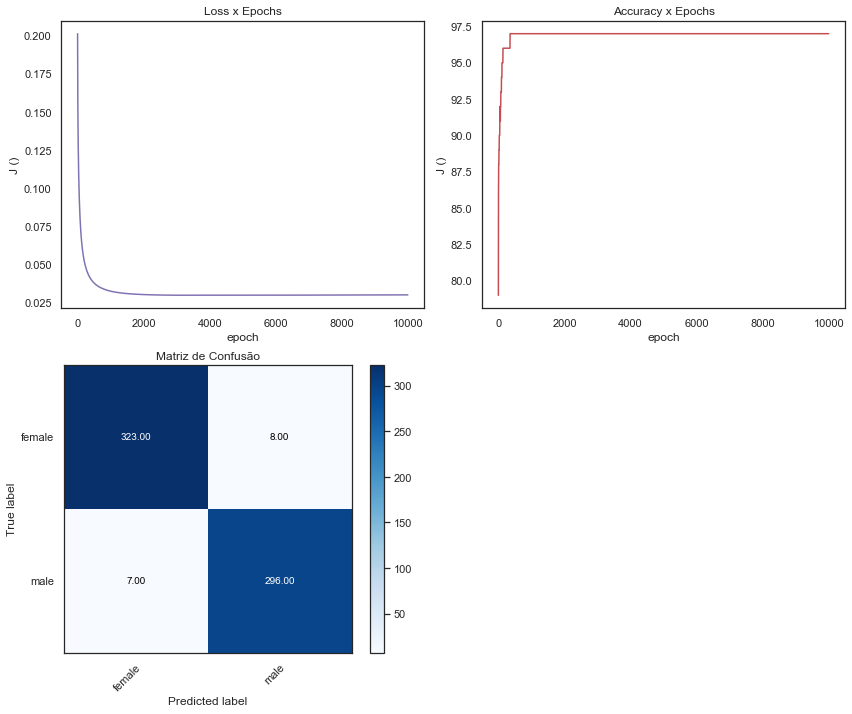

In [18]:
cfm = confusion_matrix(y_test.astype(np.int), y_pred.astype(np.int))

plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.title("Loss x Epochs")
plt.xlabel("epoch")
plt.ylabel("J ()")
plt.plot(J, color="C4")
plt.subplot(2, 2, 2)
plt.title("Accuracy x Epochs")
plt.xlabel("epoch")
plt.ylabel("J ()")
plt.plot(ACC, color="C3")
ax = plt.subplot(2, 2, 3)
im = plt.imshow(cfm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cfm.shape[1]),
       yticks=np.arange(cfm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=["female", "male"], yticklabels=["female", "male"],
       title="Matriz de Confusão",
       ylabel='True label',
       xlabel='Predicted label')
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
# Loop over data dimensions and create text annotations.
thresh = cfm.max() / 2.
for i in range(cfm.shape[0]):
    for j in range(cfm.shape[1]):
        ax.text(j, i, format(cfm[i, j], '.2f'),
                ha="center", va="center",
                color="white" if cfm[i, j] > thresh else "black")
ax.set_xlim(-0.5, 1.5)
ax.set_ylim(1.5, -0.5)
plt.tight_layout()
plt.show()

Após a análise exploratória dos dados e a verificação de qual o melhor threshold do classificador de Regressão Logística é possível notar a relativa precisão do classificador permitindo que o mesmo tenha um bom grau de generalização mesmo nos dados de teste. Dito isto a análise exploratória e mesmo a escolha das features e hiperparâmetros podem influenciar na melhor ou pior generalização do modelo.

$~$

### Parte 2 - Classificação Multi Classe

$~$

**Problema:** identificação de atividade humana usando dados de smartphones

**Dataset:** https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones

In [19]:
def read_dataset(filename, ground_truth=False):
    columns = []
    with open(filename, "r") as fh:
        for line in fh.readlines():
            columns.append([float(col) for col in line.strip().split()])
    if ground_truth:
        columns = np.array(columns).flatten().astype(np.int)
    return pd.DataFrame(columns)

har_x_train = read_dataset("./har_smartphone/X_train.txt")
har_x_test = read_dataset("./har_smartphone/X_test.txt")
har_y_train = read_dataset("./har_smartphone/y_train.txt", ground_truth=True)
har_y_test = read_dataset("./har_smartphone/y_test.txt", ground_truth=True)

Em primeiro lugar será feita a leitura do dataset e apresentação de algumas das informações.

O dataset contém informações pré-processadas das leituras de acelerômetros e giroscópio de aparelhos celulares.

Abaixo algumas informações numéricas do dataset.

In [20]:
print(f"Quantidade de amostras para treinamento : {har_x_train.shape[0]}")
print(f"Quantidade de amostras para teste       : {har_x_test.shape[0]}")
print(f"Quantidade total de colunas (features)  : {har_x_train.shape[1]}")

print()
print("Apresentação dos primeiros 2 registros e algumas colunas:")
print("-" * 30)
print(har_x_train.head(2))

Quantidade de amostras para treinamento : 7352
Quantidade de amostras para teste       : 2947
Quantidade total de colunas (features)  : 561

Apresentação dos primeiros 2 registros e algumas colunas:
------------------------------
        0         1         2         3         4         5         6    \
0  0.288585 -0.020294 -0.132905 -0.995279 -0.983111 -0.913526 -0.995112   
1  0.278419 -0.016411 -0.123520 -0.998245 -0.975300 -0.960322 -0.998807   

        7         8         9    ...       551       552       553       554  \
0 -0.983185 -0.923527 -0.934724  ... -0.074323 -0.298676 -0.710304 -0.112754   
1 -0.974914 -0.957686 -0.943068  ...  0.158075 -0.595051 -0.861499  0.053477   

        555       556       557       558       559       560  
0  0.030400 -0.464761 -0.018446 -0.841247  0.179941 -0.058627  
1 -0.007435 -0.732626  0.703511 -0.844788  0.180289 -0.054317  

[2 rows x 561 columns]


$~$

**a**) Modelo de Regressão Logística

Para este exercício foi utilizado o modelo criado previamente no exercício anterior, o qual sofreu alterações para a possibilidade de expandi-lo para a classificação multiclasse. Neste sentido foi implementada a função softmax dada pela seguinte fórmula.

$~$

$y = \frac{exp(z)}{\sum{exp(z)}}$

$~$

Os dados brutos do dataset foram usados diretamente no modelo de Regressão Logística usando a camada de softmax para determinar as classes. Não há necessidade de normalização ou qualquer outro tipo de pré-processamento, visto que, como mencionado os dados já foram pré-processados.

Os resultados foram muito positivos dada a quantidade de informação e o tipo da mesma (dados de sensores).

Como o modelo utilizado é o mesmo que o implementado anterior, o único parâmetro que foi alterado para os resultados abaixo, foi o learning rate (valor de 1e-1).

Definido como métrica para os resultados a precisão, recall e f1-score. Todas métricas, além da acurácia que permitem analisar melhor como o modelo se comportou para a classificação de cada classe.

Abaixo, a apresentação dos resultados.

In [21]:
x_har_train = har_x_train.to_numpy()
x_har_test = har_x_test.to_numpy()
y_har_train = har_y_train.to_numpy().flatten()
y_har_test = har_y_test.to_numpy().flatten()

In [22]:
# Logistic function
clfsft = LogisticRegressionImpl()
J, ACC = clfsft.train(x_har_train, y_har_train, lr=1e-1)

In [23]:
y_har_pred = clfsft.predict(x_har_test)
y_har_test_on = np.argmax(one_hot_encode(y_har_test), axis=1)

print("Aplicando o classificador no conjunto de teste")
print("-" * 30)
print()

print("Acurácia:")
print("-" * 30)
print(f"Acertos: {np.round(accuracy_score(y_har_test_on, y_har_pred) * 100, 2)}%")
print(f"Erros  : {np.round((1-accuracy_score(y_har_test_on, y_har_pred)) * 100, 2)}%")

print()
print("Relatório de Classificação:")
print("-" * 30)
report = classification_report(y_har_test_on + 1, y_har_pred + 1, output_dict=True)
items = []
for key, value in report.items():
    if isinstance(value, dict) and key.isdigit():
        items.append([
            key,
            np.round(value["precision"], 2),
            np.round(value["recall"], 2),
            np.round(value["f1-score"], 2),
            np.round(value["support"], 2)
        ])
dfclass = pd.DataFrame(items, columns=["Classe", "Precisão", "Recall", "F1-Score", "Support"])
print(dfclass)

Aplicando o classificador no conjunto de teste
------------------------------

Acurácia:
------------------------------
Acertos: 94.71%
Erros  : 5.29%

Relatório de Classificação:
------------------------------
  Classe  Precisão  Recall  F1-Score  Support
0      1      0.94    0.99      0.96      496
1      2      0.93    0.95      0.94      471
2      3      0.98    0.91      0.94      420
3      4      0.94    0.88      0.91      491
4      5      0.90    0.95      0.92      532
5      6      1.00    1.00      1.00      537


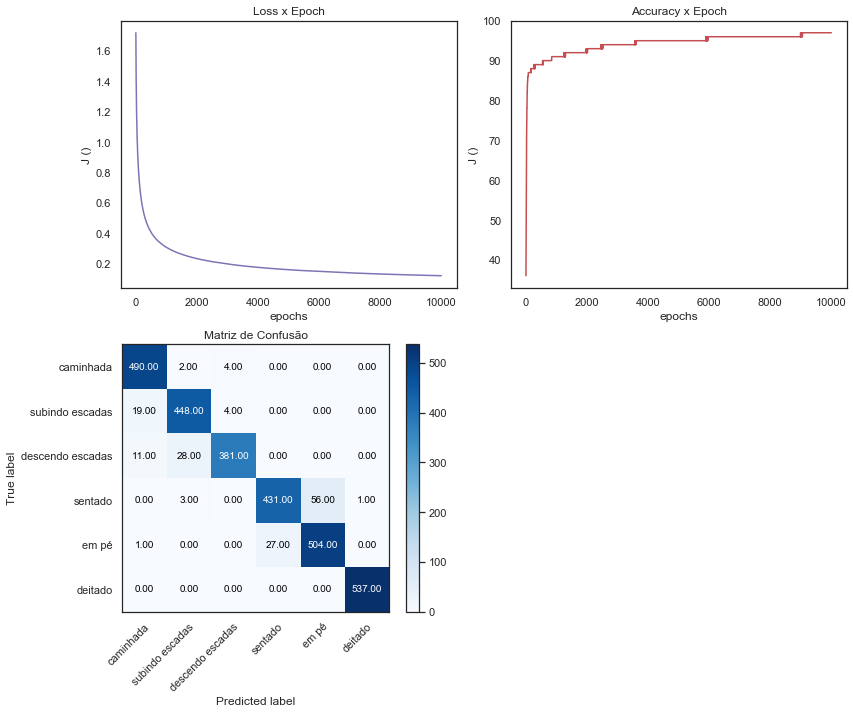

In [24]:
labels = ["caminhada", "subindo escadas", "descendo escadas", "sentado", "em pé", "deitado"]
cfm = confusion_matrix(y_har_test_on, y_har_pred)

plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.title("Loss x Epoch")
plt.xlabel("epochs")
plt.ylabel("J ()")
plt.plot(J, color="C4")
plt.subplot(2, 2, 2)
plt.title("Accuracy x Epoch")
plt.xlabel("epochs")
plt.ylabel("J ()")
plt.plot(ACC, color="C3")

ax = plt.subplot(2, 2, 3)
im = plt.imshow(cfm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cfm.shape[1]),
       yticks=np.arange(cfm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=labels, yticklabels=labels,
       title="Matriz de Confusão",
       ylabel='True label',
       xlabel='Predicted label')
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
# Loop over data dimensions and create text annotations.
thresh = cfm.max() / 2.
for i in range(cfm.shape[0]):
    for j in range(cfm.shape[1]):
        ax.text(j, i, format(cfm[i, j], '.2f'),
                ha="center", va="center",
                color="white" if cfm[i, j] > thresh else "black")
ax.set_xlim(-0.5, 5.5)
ax.set_ylim(5.5, -0.5)
plt.tight_layout()
plt.show()

É evidente que mesmo modelos mais simples (diferentemente de Redes Neurais Profundas), pode sanar problemas que muitas vezes parecem ser complexos e com uma dinâmica aparentemente caótica.

Dessa maneira, pode ser muito interessante, avaliar os dados em modelos simples antes mesmo de partir para abordagens mais complexas e que necessitam de melhor tuning de parâmetros.

$~$

**b)** Implementação do kNN e variação do hiperparâmetro k.

Neste exercício foi implementado o algoritmo de classificação K Nearest Neighbors. A distância entre os padrões é calculada utilizando-se a distância euclidiana.

$~$

$w=\sqrt{(\sum{a}-{b})^2}$

$~$

Como parametrização do algoritmo é possível selecionar dois parametros.

O primeiro deles é o valor dos K vizinhos, dessa maneira, é possível selecionar a quantidade exata de vizinhos para se avaliar a qual classe o novo padrão deve vir a pertencer. O Valor padrão de K é 5.

O outro parâmetro criado é a heurística para determinar a classe baseada na distância. Neste sentido foram implementadas duas heurísticas: *uniform* e *distance*

 - *uniform*: Heurística padrão do modelo, e mais simples, defini a classe do novo padrão, verificando qual a maior quantidade de classes dos padrões mais próximos. Ou seja, tendo 5 padrões mais próximos daquele que se deseja classificar, a classe definida será a que possuir maior número dentro destes 5 padrões. Em caso de empate, opta-se pela classe que possui o padrão com menor distância (o mais próximo).
 - *distance*: Implementa uma heurística um pouco mais complexa que a de cima, ao invés de escolher apenas a classe que possui maior quantidade de padrões, calcula a IDW (Inverse distance weight) de cada classe para os K padrões.

$~$

$y = max_r (\sum_{i=1}^k d_i 1_{y(i)=r})$

$~$

onde d é o vetor invertido com o cálculo das distâncias para cada padrão, r é a quantidade de classes.

$~$

$d_i = \frac{1}{w_i}$

In [25]:
%load_ext cython

In [133]:
%%cython

import numpy as np
cimport numpy as npc

cpdef npc.ndarray euclidiana(npc.ndarray a, npc.ndarray b):
    return np.sqrt(np.sum(np.square(a - b), axis=1))

cpdef npc.ndarray calcular_distancias(npc.ndarray xt, npc.ndarray _x, npc.ndarray _y):
    return np.c_[_y, euclidiana(xt, _x)]
    # return [(_y[t], dists[t]) for t, xx in enumerate(_x)]
    # return [(_y[t], euclidiana(xt, xx)) for t, xx in enumerate(_x)]

In [141]:
def compute_knn(_heuristic, _k, _x, _y, xt):
    # Calcular as distancias
    distancias = pd.DataFrame(calcular_distancias(xt, _x, _y), columns=["cls", "dist"])
    # distancias.sort(key=operator.itemgetter(1))
    distancias = distancias.sort_values(by="dist")
    # Pegar os primeiros K resultados
    dist = np.asarray(distancias[:_k])
    # Verificar quais dos resultados deve-se usar
    unique, counts = np.unique(dist[:, 0], return_counts=True)
    # Pontos baseando-se na distancia invertida dos melhores resultados
    if _heuristic == "distance":
        cls = {u: np.sum(1./dist[dist[:, 0] == u][:, 1]) for u in unique}
        return int(max(cls, key=cls.get))
    # Todos os pontos tem o mesmo peso
    cmax = np.where(counts == np.max(counts))[0][0]
    return int(unique[cmax])


class KNeighborsClassifierImpl:
    
    def __init__(self, k=5, heuristic="uniform"):
        self._k = k
        if "uniform" in heuristic:
            self._heuristic = "uniform"
        else:
            self._heuristic = "distance"
    
    def fit(self, x, y):
        permutation = np.random.permutation(x.shape[0])
        self._x, self._y = x[permutation, :], y[permutation,]
    
    def predict(self, x_test):
        with ProcessPoolExecutor(max_workers=8) as exc:
            y_pred = list(exc.map(partial(compute_knn, self._heuristic, self._k, self._x, self._y), x_test, chunksize=250))
        return np.asarray(y_pred)

In [143]:
xn_har_train, xn_har_test, yn_har_train, yn_har_test = train_test_split(x_har_train, y_har_train, train_size=0.75, random_state=42, shuffle=False)
best_acc, best_f1, best_k, best_m = 0, 0, 1, "uniform"
ACC = {"uniform": [], "distance": []}
F1 = {"uniform": [], "distance": []}
for k in range(1, 21):
    for heuristic in ACC.keys():
        # start = time.time()
        knn = KNeighborsClassifierImpl(k=k, heuristic=heuristic)
        knn.fit(xn_har_train, yn_har_train)
        y_har_pred = knn.predict(xn_har_test)
        acc = np.round((np.sum(yn_har_test == y_har_pred) / len(xn_har_test)) * 100, 2)
        report = classification_report(yn_har_test, y_har_pred, output_dict=True)
        f1_score = np.mean([value["f1-score"] for value in report.values() if isinstance(value, dict)])
        if acc > best_acc:
            best_f1 = f1_score
            best_k = k
            best_m = heuristic
            best_acc = acc
        elif acc == best_acc:
            if f1_score > best_f1:
                best_f1 = f1_score
                best_k = k
                best_m = heuristic
                best_acc = acc
        ACC[heuristic].append(acc)
        F1[heuristic].append(f1_score)
        # print(time.time() - start)

Abaixo, são apresentados os gráficos das validações do modelo, foram realizados a validação do valor de K variando de 1 até 20 e claro, para ambas as heurísticas de classificação *uniform* e *distance*.

No caso, o dataset de treinamento foi dividido em 2 partes, sendo 75% para "treino" e 25% para "validação".

Para a escolha do melhor valor de K, em um primeiro caso a métrica escolhida foi a Acurácia, e em caso de valores de K com mesmo Acurácia calculou-se a F-Medida como método de desempate (se mesmo assim ambas forem iguais, o valor de K não será atualizado para o novo, ficando o antigo valor como o eleito).

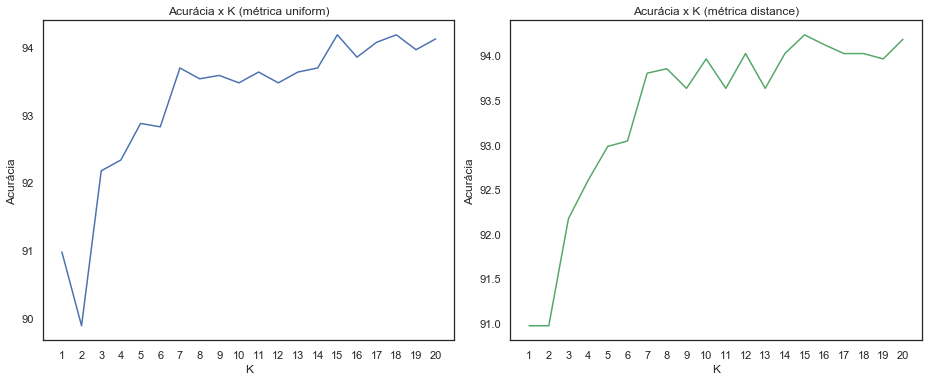

In [150]:
plt.figure(figsize=(13, 10))

plt.subplot(2, 2, 1)
plt.title("Acurácia x K (métrica uniform)")
plt.plot(range(1, 21), ACC["uniform"])
plt.xticks(range(1, 21))
plt.xlabel("K")
plt.ylabel("Acurácia")

plt.subplot(2, 2, 2)
plt.title("Acurácia x K (métrica distance)")
plt.plot(range(1, 21), ACC["distance"], "g")
plt.xticks(range(1, 21))
plt.xlabel("K")
plt.ylabel("Acurácia")

plt.tight_layout()
plt.show()

In [146]:
knn = KNeighborsClassifierImpl(k=8, heuristic=best_m)
knn.fit(x_har_train, y_har_train)
y_har_pred = knn.predict(x_har_test)
acc = np.sum(y_har_test == y_har_pred) / len(x_har_test)
cfm = confusion_matrix(y_har_test, y_har_pred)

Seguindo ao informado acima, é selecionado o melhor valor de K baseado na acurácia nos dados de "treino" e validação.

Abaixo são apresentadas as métricas e a matriz de confusão para esse melhor valor de K nos dados de teste.

Melhores valores
------------------------------
K        : 15
Métrica  : distance
Acurácia : 90.97%

Relatório de Classificação:
------------------------------
  Classe  Precisão  Recall  F1-Score  Support
0      1      0.86    0.97      0.92      496
1      2      0.90    0.90      0.90      471
2      3      0.95    0.81      0.88      420
3      4      0.91    0.82      0.86      491
4      5      0.85    0.93      0.89      532
5      6      1.00    0.99      1.00      537


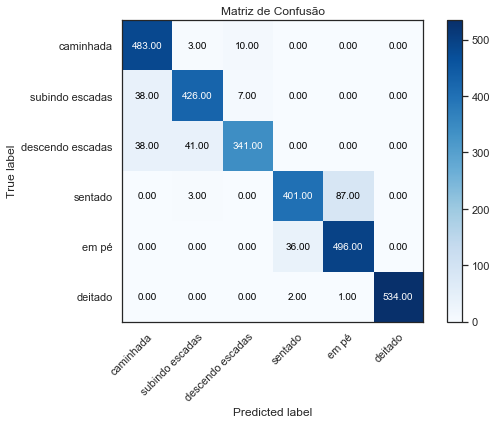

In [148]:
print(f"Melhores valores")
print("-" * 30)
print(f"K        : {best_k}")
print(f"Métrica  : {best_m}")
print(f"Acurácia : {np.round(acc * 100, 2)}%")

print()
print("Relatório de Classificação:")
print("-" * 30)
report = classification_report(y_har_test, y_har_pred, output_dict=True)
items = []
for key, value in report.items():
    if isinstance(value, dict) and key.isdigit():
        items.append([
            key,
            np.round(value["precision"], 2),
            np.round(value["recall"], 2),
            np.round(value["f1-score"], 2),
            np.round(value["support"], 2)
        ])
dfclass = pd.DataFrame(items, columns=["Classe", "Precisão", "Recall", "F1-Score", "Support"])
print(dfclass)

labels = ["caminhada", "subindo escadas", "descendo escadas", "sentado", "em pé", "deitado"]

plt.figure(figsize=(8, 6))

ax = plt.subplot(1, 1, 1)
im = plt.imshow(cfm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cfm.shape[1]),
       yticks=np.arange(cfm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=labels, yticklabels=labels,
       title="Matriz de Confusão",
       ylabel='True label',
       xlabel='Predicted label')
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
# Loop over data dimensions and create text annotations.
thresh = cfm.max() / 2.
for i in range(cfm.shape[0]):
    for j in range(cfm.shape[1]):
        ax.text(j, i, format(cfm[i, j], '.2f'),
                ha="center", va="center",
                color="white" if cfm[i, j] > thresh else "black")
ax.set_xlim(-0.5, 5.5)
ax.set_ylim(5.5, -0.5)

plt.tight_layout()
plt.show()

Por fim, após a execução do método KNN, é possível dizer que mesmo um método não-paramétrico é capaz de atingir resultados relativamente ótimos. Claro que nessa avaliação é importante salientar que os dados e consequentemente a relação entre cada uma das features permitem um excelente desempenho.

Dessa maneira, quando da escolha do melhor modelo ou método, para a abordagem de determinado problema, faz-se importante a avaliação de diversos, entendendo claro a peculiaridade de cada um e dos dados que se tem a disposição.

$~$

Rodolfo De Nadai - 208911

Anthony Miranda Vieira - 229058

Todo o código deste relatório esta disponível em: https://github.com/rdenadai/ia006c